In [1]:
import json

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from music21 import stream, chord, note, midi

import pygame
from IPython.display import Audio

from sklearn.cluster import KMeans
from collections import Counter

pygame 2.6.0 (SDL 2.28.4, Python 3.11.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Motif of a women's shirt from Samokov Region

### Load the Colour to Notes mapping

In [2]:
# Load data from JSON file
with open('../color_data.json', 'r') as json_file:
    color_data = json.load(json_file)

# Convert RGB values from lists to tuples for immutability
target_colors = [tuple(data["RGB"]) for data in color_data.values()]

# Create color_to_note mapping with tuples as keys
color_to_note = {tuple(data["RGB"]): data["Note"] for data in color_data.values()}

## Image Crop 

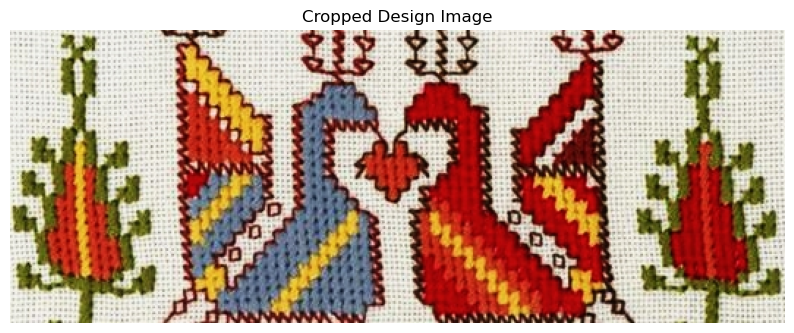

Cropped image saved to ../Images/Cropped_Design_image.png


In [3]:
# Load the design image
design_image_path = '../Images/Original_2.JPG'
design_image = cv2.imread(design_image_path)

# Check if the image was loaded successfully
if design_image is None:
    raise FileNotFoundError(f"Unable to load image at path: {design_image_path}")

# Calculate the coordinates for cropping
start_x = 20
end_x = design_image.shape[1] - 22
start_y = 101
end_y = design_image.shape[0] - 100

# Perform the cropping
cropped_image = design_image[start_y:end_y, start_x:end_x]

# Convert the cropped image to RGB
cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

# Display the cropped image
plt.figure(figsize=(10, 5))
plt.title('Cropped Design Image')
plt.imshow(cropped_image_rgb)
plt.axis('off')  # Hide axis
plt.show()

# Save the cropped image
output_path = '../Images/Cropped_Design_image.png'
cv2.imwrite(output_path, cv2.cvtColor(cropped_image_rgb, cv2.COLOR_RGB2BGR))
print(f"Cropped image saved to {output_path}")


Next steps are to dimish the number of the colors and the image size.

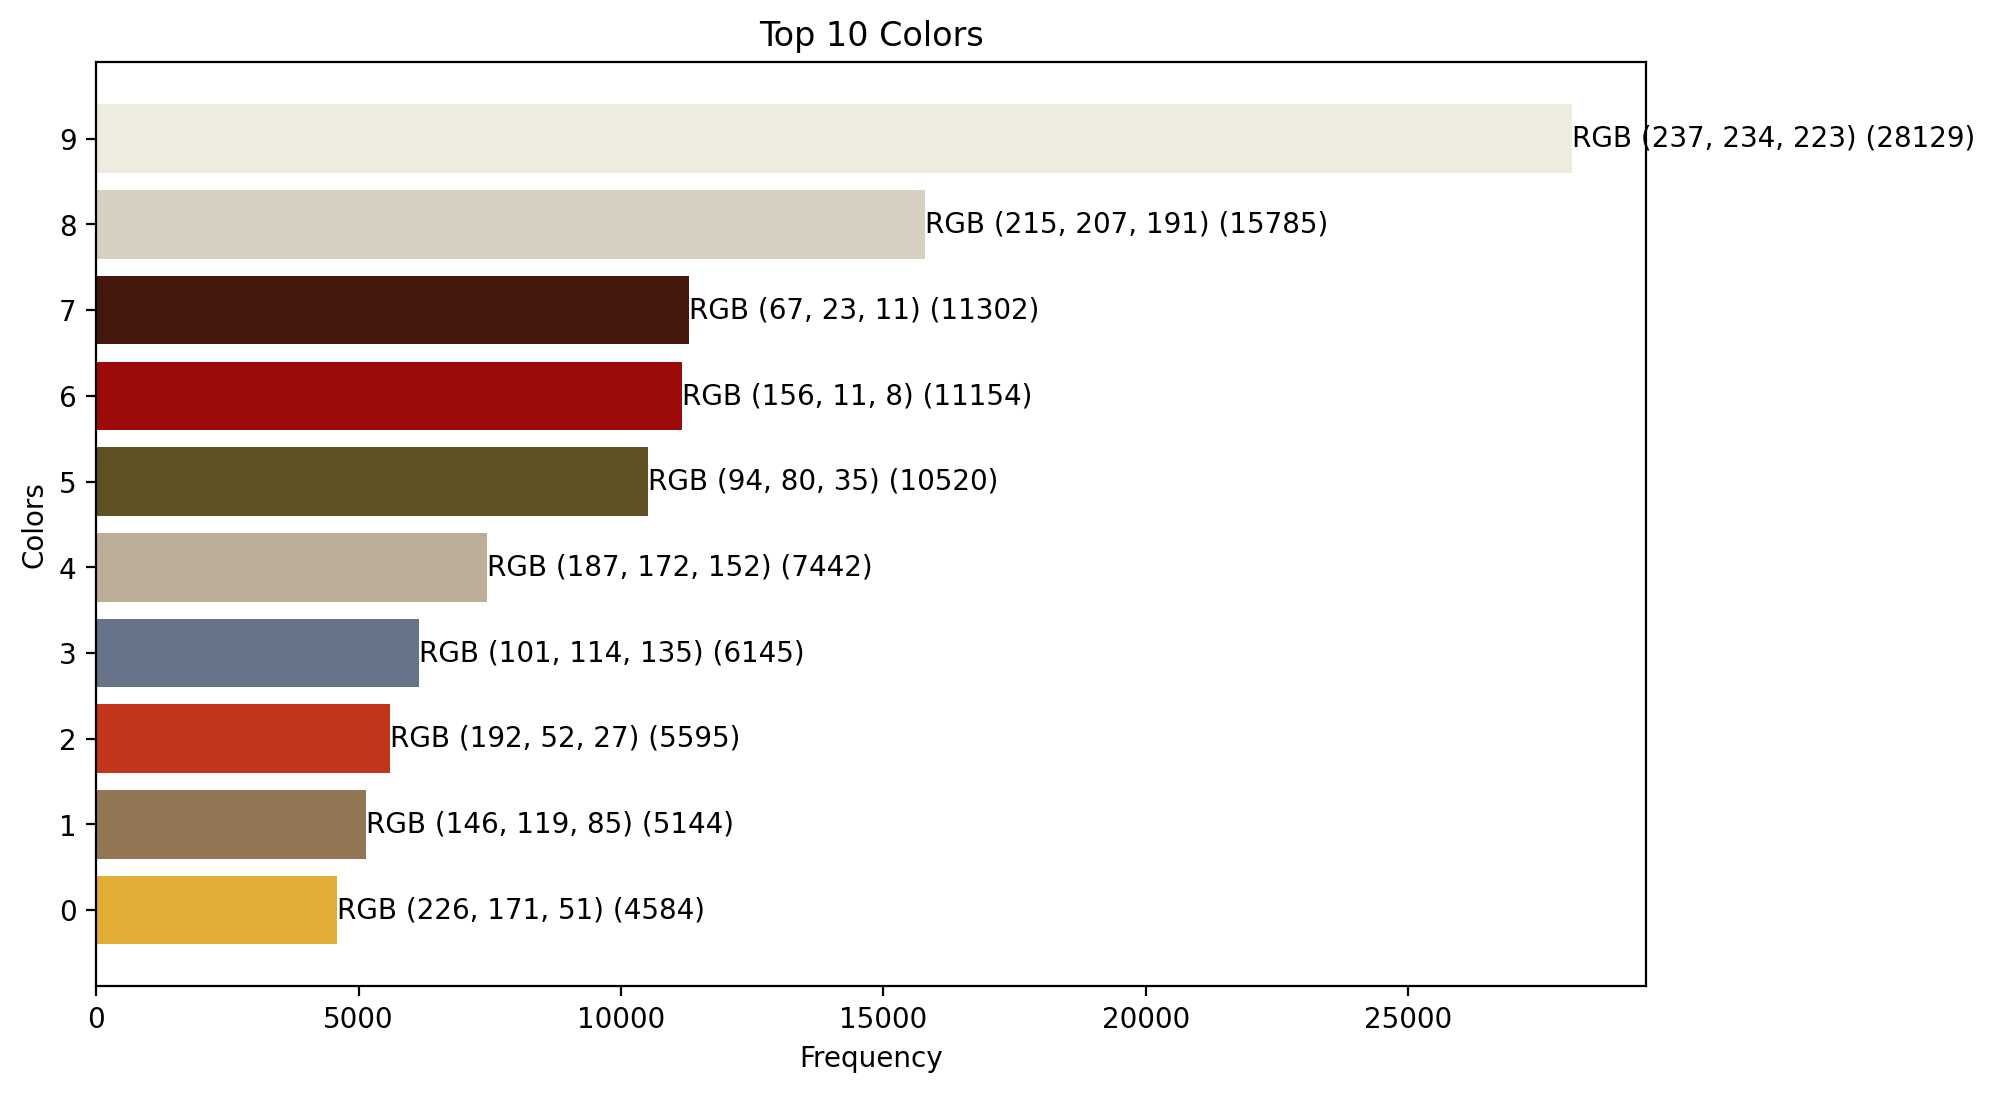

In [4]:
# Load the image
image_path = '../Images/Cropped_Design_image.png'
image = cv2.imread(image_path)

# Convert the image from BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Reshape the image to a 2D array of pixels
pixels = image_rgb.reshape(-1, 3)

# Use KMeans to find the top 10 colors
num_colors = 10
kmeans = KMeans(n_clusters=num_colors, n_init=10)  # Set n_init explicitly
kmeans.fit(pixels)

# Get the colors and their frequencies
colors = kmeans.cluster_centers_
labels = kmeans.labels_
label_counts = Counter(labels)

# Sort the colors by frequency
sorted_colors = [colors[i] for i in label_counts.keys()]
sorted_counts = [label_counts[i] for i in label_counts.keys()]
sorted_indices = np.argsort(sorted_counts)[::-1]

top_colors = np.array(sorted_colors)[sorted_indices]
top_counts = np.array(sorted_counts)[sorted_indices]

# Display the top ten colors
def plot_colors(colors, counts):
    # Sort colors and counts by frequency in acending order
    sorted_indices = np.argsort(counts)[::1]
    sorted_colors = np.array(colors)[sorted_indices]
    sorted_counts = np.array(counts)[sorted_indices]
    
    plt.figure(figsize=(10, 6))
    plt.title('Top 10 Colors')
    
    # Create horizontal bar plot
    bars = plt.barh(range(len(sorted_colors)), sorted_counts, color=sorted_colors / 255)
    
    # Add color labels next to each bar
    for bar, color, count in zip(bars, sorted_colors, sorted_counts):
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                 f'RGB {tuple(map(int, color))} ({count})', 
                 va='center', ha='left', fontsize=10)

    plt.xlabel('Frequency')
    plt.ylabel('Colors')
    plt.yticks(range(len(sorted_colors)))
    plt.show()

# Plot the top ten colors
plot_colors(top_colors[:num_colors], top_counts[:num_colors])


In [5]:
image_path = "../Images/Cropped_Design_image.png"
img = Image.open(image_path)

# Resize the image to 74x
img_resized = img.resize((74, 25), Image.NEAREST)

# Function to find the nearest color from the target palette
def closest_color(pixel, colors):
    colors = np.array(colors)
    distances = np.sqrt(np.sum((colors - pixel) ** 2, axis=1))
    return colors[np.argmin(distances)]

# Get the image data as a numpy array
pixels = np.array(img_resized)

# Create an array to hold the new pixel data
new_pixels = np.zeros_like(pixels)

# Map each pixel to the nearest color in the palette
for i in range(pixels.shape[0]):
    for j in range(pixels.shape[1]):
        new_pixels[i, j] = closest_color(pixels[i, j], target_colors)

# Convert the new pixel array back to an image
new_img = Image.fromarray(new_pixels.astype('uint8'), 'RGB')

# Save the new image
new_image_path = "../Images/Pixelated_Image_Converted.png"
new_img.save(new_image_path)


In [6]:
# Load the design image
design_image_path = '../Images/Pixelated_Image_Converted.png'
design_image = cv2.imread(design_image_path)

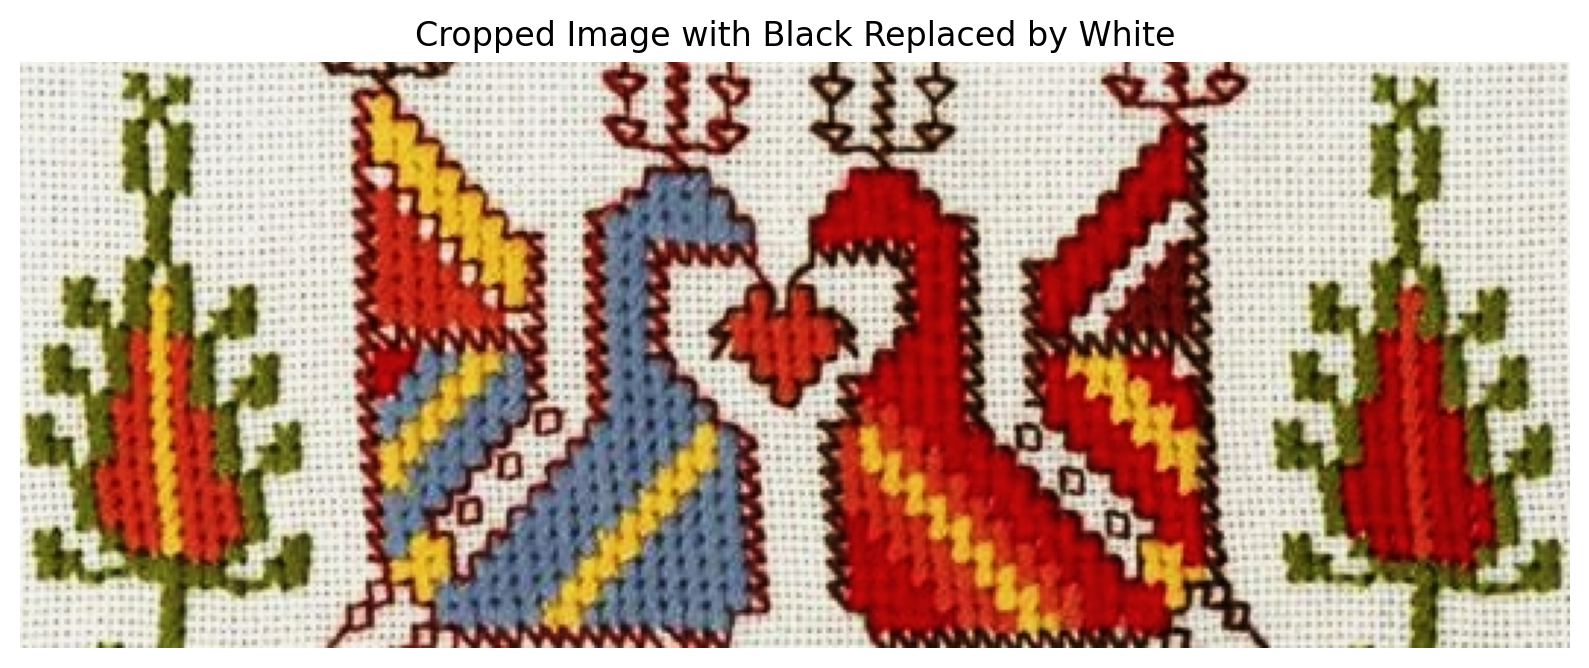

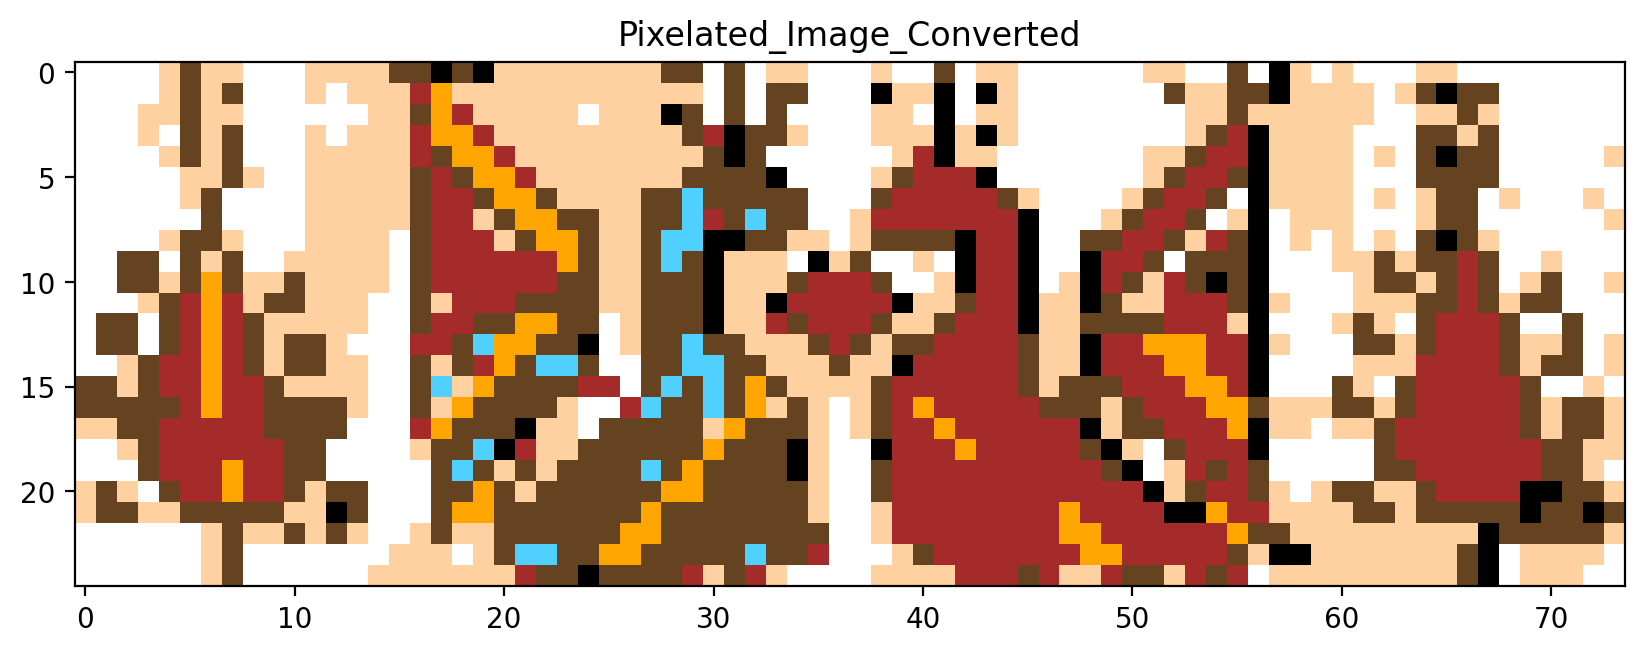

In [7]:
# Display the modified image
plt.figure(figsize=(10, 5))
plt.title('Cropped Image with Black Replaced by White')
plt.imshow(cropped_image_rgb)
plt.axis('off')
plt.show()

# Convert BGR image to RGB
design_image_rgb = cv2.cvtColor(design_image, cv2.COLOR_BGR2RGB)

# Display the pixelated image in RGB format
plt.figure(figsize=(10, 5))
plt.title('Pixelated_Image_Converted')
plt.imshow(design_image_rgb)
plt.show()


The resulting image could be improved by applying 2 masks:
1. Replacing the pale pink colour with white (background)
2. Replacing the dark brown colour on the left and right (tree figures) with green

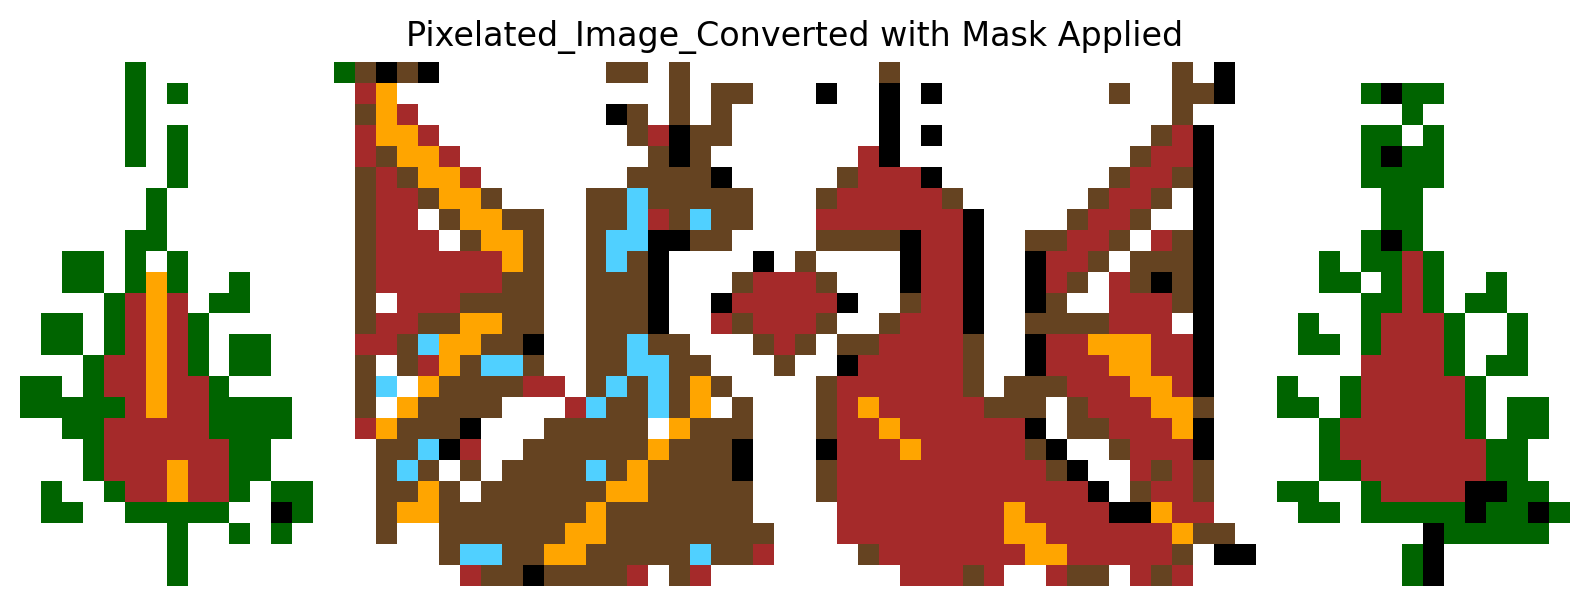

In [8]:
# Define the mask areas and the target colour (remove the pale pink colour from the background)
mask_width = 74
target_color = np.array([255, 208, 160])  # Pale Pink color

# Apply the mask on the left side
for i in range(design_image_rgb.shape[0]):
    for j in range(mask_width):
        if np.array_equal(design_image_rgb[i, j], target_color):
            design_image_rgb[i, j] = [255, 255, 255]  # White

# Define the mask areas and the target colour (tree figures)
left_mask_width = 16
target_color = np.array([101, 67, 33])  # Dark Brown color

# Apply the mask on the left side
for i in range(design_image_rgb.shape[0]):
    for j in range(left_mask_width):
        if np.array_equal(design_image_rgb[i, j], target_color):
            design_image_rgb[i, j] = [0, 100, 0]  # Dark Green

right_mask_width = 16
# Apply the mask on the right side
for i in range(design_image_rgb.shape[0]):
    for j in range(design_image_rgb.shape[1] - right_mask_width, design_image_rgb.shape[1]):
        if np.array_equal(design_image_rgb[i, j], target_color):
            design_image_rgb[i, j] = [0, 100, 0]  # Dark Green

# Display the pixelated image with masks applied in RGB format
plt.figure(figsize=(10, 5))
plt.title('Pixelated_Image_Converted with Mask Applied')
plt.imshow(design_image_rgb)
plt.axis('off')
plt.show()

It is time to convert the pixelated image into music chords. Each column will represent one chord (combination between one or more notes, or silence). The notes are related to the colours. To simplify the model, I will remove the duplicated colours in the columns.

In [9]:
design_image_array = np.array(design_image)

In [10]:
# Function to convert BGR to RGB
def bgr_to_rgb(bgr_color):
    return bgr_color[:, :, ::-1]

# Function to get unique colors for each column in RGB order
def unique_colors_by_column(array):
    height, width, _ = array.shape
    unique_colors = []
    
    # Convert the entire image array from BGR to RGB
    rgb_array = bgr_to_rgb(array)
    
    # Iterate over each column
    for col in range(width):
        # Extract the column data across all rows
        column_data = rgb_array[:, col, :]
        
        # Find unique colors in this column
        unique_colors_col = np.unique(column_data, axis=0)
        
        unique_colors.append(unique_colors_col)
    
    return unique_colors

# Get unique colors for each column
unique_colors = unique_colors_by_column(design_image_array)

# Create a list of unique colors for each column
unique_colors_list = [list(map(tuple, colors)) for colors in unique_colors]

# Output the list of unique colors
print(unique_colors_list)


[[(101, 67, 33), (255, 208, 160), (255, 255, 255)], [(101, 67, 33), (255, 208, 160), (255, 255, 255)], [(101, 67, 33), (255, 208, 160), (255, 255, 255)], [(101, 67, 33), (255, 208, 160), (255, 255, 255)], [(101, 67, 33), (165, 42, 42), (255, 208, 160), (255, 255, 255)], [(101, 67, 33), (165, 42, 42), (255, 208, 160), (255, 255, 255)], [(101, 67, 33), (165, 42, 42), (255, 165, 0), (255, 208, 160)], [(101, 67, 33), (165, 42, 42), (255, 165, 0), (255, 208, 160), (255, 255, 255)], [(101, 67, 33), (165, 42, 42), (255, 208, 160), (255, 255, 255)], [(101, 67, 33), (165, 42, 42), (255, 208, 160), (255, 255, 255)], [(101, 67, 33), (255, 208, 160), (255, 255, 255)], [(101, 67, 33), (255, 208, 160), (255, 255, 255)], [(0, 0, 0), (101, 67, 33), (255, 208, 160), (255, 255, 255)], [(101, 67, 33), (255, 208, 160), (255, 255, 255)], [(255, 208, 160), (255, 255, 255)], [(101, 67, 33), (255, 208, 160), (255, 255, 255)], [(101, 67, 33), (165, 42, 42), (255, 208, 160), (255, 255, 255)], [(0, 0, 0), (80, 2

In [11]:
#find unique colors:

# Flatten the list of lists
flat_list = [color for sublist in unique_colors_list for color in sublist]

# Get unique colors
unique_colors = set(flat_list)

# Convert to a sorted list for easier readability (optional)
unique_colors = sorted(unique_colors)

# Print unique colors
print("Unique colors:")
for color in unique_colors:
    print(color)


Unique colors:
(0, 0, 0)
(80, 208, 255)
(101, 67, 33)
(165, 42, 42)
(255, 165, 0)
(255, 208, 160)
(255, 255, 255)


In [12]:
# Map each color to its musical note
mapped_notes_list = []
for column in unique_colors_list:
    notes = [color_to_note.get(color, "Unknown") for color in column]
    mapped_notes_list.append(notes)

# Output the list of mapped notes
print(mapped_notes_list)


[['C4', 'D4', 'Rest'], ['C4', 'D4', 'Rest'], ['C4', 'D4', 'Rest'], ['C4', 'D4', 'Rest'], ['C4', 'F4', 'D4', 'Rest'], ['C4', 'F4', 'D4', 'Rest'], ['C4', 'F4', 'Bb3', 'D4'], ['C4', 'F4', 'Bb3', 'D4', 'Rest'], ['C4', 'F4', 'D4', 'Rest'], ['C4', 'F4', 'D4', 'Rest'], ['C4', 'D4', 'Rest'], ['C4', 'D4', 'Rest'], ['Rest', 'C4', 'D4', 'Rest'], ['C4', 'D4', 'Rest'], ['D4', 'Rest'], ['C4', 'D4', 'Rest'], ['C4', 'F4', 'D4', 'Rest'], ['Rest', 'D3', 'C4', 'F4', 'Bb3', 'D4'], ['D3', 'C4', 'F4', 'Bb3', 'D4', 'Rest'], ['Rest', 'D3', 'C4', 'F4', 'Bb3', 'D4'], ['Rest', 'C4', 'F4', 'Bb3', 'D4'], ['Rest', 'D3', 'C4', 'F4', 'Bb3', 'D4'], ['D3', 'C4', 'F4', 'Bb3', 'D4'], ['D3', 'C4', 'Bb3', 'D4'], ['Rest', 'C4', 'F4', 'D4', 'Rest'], ['C4', 'F4', 'Bb3', 'D4', 'Rest'], ['C4', 'F4', 'Bb3', 'D4', 'Rest'], ['D3', 'C4', 'Bb3', 'D4'], ['Rest', 'D3', 'C4', 'Bb3', 'D4'], ['D3', 'C4', 'F4', 'Bb3', 'D4'], ['Rest', 'D3', 'C4', 'F4', 'Bb3', 'D4', 'Rest'], ['Rest', 'C4', 'Bb3', 'D4'], ['D3', 'C4', 'F4', 'Bb3', 'D4', 'Rest

In [13]:
# Create a stream for the MIDI data
midi_stream = stream.Stream()

# Convert each chord to music21 objects and add to the stream
for chord_notes in mapped_notes_list:
    chord_notes = [note for note in chord_notes if note != 'Rest']
    if chord_notes:
        midi_stream.append(chord.Chord(chord_notes))
    else:
        midi_stream.append(note.Rest())

# Set the duration of each note/chord (assuming quarter notes for simplicity)
for element in midi_stream:
    element.quarterLength = 1.0

# Create a MIDI file
mf = midi.translate.music21ObjectToMidiFile(midi_stream)

# Write the MIDI file to disk
mf.open('../Outputs/output3.mid', 'wb')
mf.write()
mf.close()


In [14]:
# Initialize pygame
pygame.mixer.init()
pygame.mixer.music.load("../Outputs/output3.mid")
pygame.mixer.music.play()


### Bonus
After additional processing with https://www.soundtrap.com/

In [15]:
audio = Audio('../BonusTrack/Three.mp3')
audio